In [1]:
from os import chdir
chdir('..')

<IPython.core.display.Javascript object>


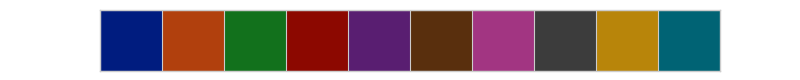

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import math
import seaborn as sns
import pandas as pd
import numpy as np
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString, asPolygon
from shapely.affinity import scale

from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly
%matplotlib notebook
sns.set(font_scale=2)  # crazy big
sns.set_style("whitegrid")
current_palette = sns.color_palette('dark')
sns.palplot(current_palette)

PURPLE = current_palette[4]
PURPLE_LIGHT = current_palette[4] + (0.1, )
GREEN = current_palette[2]
GREEN_LIGHT = current_palette[2] + (0.1, )
RED = current_palette[3]
BLUE = current_palette[0]
BLUE_LIGHT = current_palette[0] + (0.1, )
ORANGE = current_palette[1]
ORANGE_LIGHT = current_palette[1] + (0.1, )
GRAY = current_palette[7] + (0.7, )
GRAY_LIGHT = current_palette[7] + (0.3, )


In [3]:
def add_arc(ax, center, radius, width, height, start_angle, end_angle, color, text_radius, text_angle, text_angle_actual=None):    
    if text_angle_actual:
        theta = text_angle_actual
    else:
        angle_diff = end_angle - start_angle
        theta = start_angle + angle_diff / 2
        theta = theta % 360 
    
    pt = np.dot(rotation_transform(theta), np.array([[1, 0]]).T).T * text_radius
    text_pt = (pt + center).squeeze()
    
    arc = ax.add_patch(Arc(center, width * radius, height * radius, 0, start_angle, end_angle, color=color,linewidth=2.0 ))
    ax.text(text_pt[0], text_pt[1], text_angle,         
            horizontalalignment='center',
            verticalalignment='center', fontsize=18, color=color)

def rotation_transform(theta):
    ''' rotation matrix given theta
    Inputs:
        theta    - theta (in degrees)
    '''
    theta = np.radians(theta)
    A = [[np.math.cos(theta), -np.math.sin(theta)],
         [np.math.sin(theta), np.math.cos(theta)]]
    return np.array(A)

def plot_points(ax, points, color='', plot_text=False, fontsize=20, **kwargs):
    ax.scatter(points[:, 0], points[:, 1], c=color, **kwargs)
    if plot_text:
        for i in range(points.shape[0]):
            center = points[i, :].copy()
            center[0] = center[0] - 0.028
            center[1] = center[1] + 0.05
            text = 'PI' + str(i)
            ax.text(center[0], center[1], text, fontsize=fontsize)
    
def plot_triangles(ax, points, triangles, mask=None, lw=1.0, **kwargs):
    ax.triplot(points[:,0], points[:, 1], triangles,  mask=mask, lw=lw, **kwargs)


def plot_circle_points(ax, points, exclude_list=[], **kwargs):
    for i in range(points.shape[0]):
        if i in exclude_list:
            continue
        point = points[i,:]
        plot_circle_point(ax, point, text=str(i), **kwargs)

def plot_circle_point(ax, point, text=None, fontsize=14, radius=0.15, color='black'):
    circle = plt.Circle(point, radius=radius, fill=False, edgecolor=color)
#     point[1] = point[1] - 0.02
    ax.add_patch(circle)
    if text:
        ax.annotate(text, xy=(point[0], point[1]-0.07), fontsize=fontsize, ha="center")
    
    
def next_half_edge(e):
    return e - 2 if e % 3 == 2 else e + 1

def get_pi(t, i):
    return t * 3 + i

def build_tri_hash(plane):
    return {t:t for t in plane}

def get360Angle(v1, v2):
    dot = np.dot(v1,v2)
    det = v1[0] * v2[1] - v1[1] * v2[0]
    ang = np.arctan2(det, dot)
    if ang < 0:
        ang += np.pi * 2;
    
    return math.degrees(ang)


def build_line_string(points, delaunay, e1):
    triangles = delaunay.triangles
    e2 = next_half_edge(e1)
    
    pi1 = triangles[e1]
    pi2 = triangles[e2]
    
    point1 = points[pi1, :]
    point2 = points[pi2,:]
    return LineString([point1, point2])    
    

def build_edge_classification(points, delaunay, plane, tri_hash):
    halfedges = delaunay.halfedges
    edgeclass = dict()
    edges = dict()
    # Loop through every triangle in the plane
    for t in plane:
        # Loop through every half edge in triangle
        for i in range(3):
            heIndex = t * 3 + i
            # get the adjacent edge of this triangle edge
            oppHe = halfedges[heIndex]
            oppT = math.floor(oppHe / 3)
            # check if this triangle (oppT) is on the convex hull or removed
            if tri_hash.get(oppT) is None:
                edgeclass[heIndex] = 'border'
                edges[heIndex] = build_line_string(points, delaunay, heIndex)
#                 print('BORDER', edges[heIndex])
            else:
                edgeclass[heIndex] = 'inner'
                edges[heIndex] = build_line_string(points, delaunay, heIndex)
#                 print('INNER', edges[heIndex])

    total_tris = int(len(delaunay.triangles) / 3)
    for t in range(total_tris):
        if tri_hash.get(t) is None:
            for i in range(3):
                heIndex = 3*t + i
                edgeclass[heIndex] = 'outside'
                edges[heIndex] = build_line_string(points, delaunay, heIndex)
#                 print('OUTSIDE', edges[heIndex])
#     outside_tris = [ for range(0, )]
                
    return edgeclass, edges
            

def is_boundary_edge(delaunay, tri_hash, e):
    halfedges = delaunay.halfedges
    edge
    if halfedges[e] == -1:
        return True
    else:
        return False
    
def plot_removed_edges(ax, points, delaunay, planes, edge_num=False, fontsize=20, **kwargs):
    tri_hash = {}
    for plane in planes:
        tri_hash_ = build_tri_hash(plane)
        tri_hash.update(tri_hash_)
    edgeclass, edges = build_edge_classification(points, delaunay, planes[0], tri_hash)
    
    for e, ls in edges.items():
        if edgeclass[e] == 'border':
            continue
        elif edgeclass[e] == 'inner':
            continue
        else:
            color = GRAY_LIGHT
        edge_text = 'HE' + str(e) if edge_num else None
        plot_arrow(ax, ls, color=color, width=0.02, scale_factor=0.75, 
                   offset=0.04, offset_side='right', shape='full',index=edge_text, length_includes_head=True, fontsize=fontsize, **kwargs)

def get_center_for_text(center, triangle_pts, text_factor=0.0, **kwargs):
    max_x = triangle_pts[:, 0].ptp()
    center_ = center.copy()
    center_[0] = center[0] - max_x * text_factor
    return center_

def plot_halftriangles(ax, points, delaunay, plane, tri_color=(BLUE, BLUE_LIGHT), shade_tri=False, tri_num=False, 
                       edge_num=False, border_edge_num_only=False, fontsize=20, text_factor=0.0, 
                       plot_border_only=False, skip_edges=[], hole_edges=[], hole_color=BLUE, **kwargs):
    tri_hash = build_tri_hash(plane)
    edgeclass, edges = build_edge_classification(points, delaunay, plane, tri_hash)
    
    triangles_idx = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
    triangle_pts = points[triangles_idx]
    triangles_centers = triangle_pts.mean(axis=1)
    
    
    for e, ls in edges.items():
        if e in hole_edges:
            edgeclass[e] = 'hole'
    
        if e in skip_edges:
            continue
        if edgeclass[e] == 'border':
            color = tri_color[0]
        elif edgeclass[e] == 'inner':
            color = GRAY
            if plot_border_only:
                continue
        elif edgeclass[e] == 'hole':
            color = hole_color
        else:
            color = GRAY_LIGHT
            continue
        edge_text = 'HE' + str(e) if edge_num else None
        if border_edge_num_only and edgeclass[e] not in ['border', 'hole']:
            edge_text = None
        plot_arrow(ax, ls, color=color, width=0.02, scale_factor=0.70, 
                   offset=0.04, offset_side='right', shape='full',index=edge_text, length_includes_head=True, fontsize=fontsize, **kwargs)


    for t in plane:
        if tri_num:
            center = triangles_centers[t,:]
            center = get_center_for_text(center, triangle_pts[t,:], text_factor)
            ax.text(center[0], center[1], 'T' + str(t), fontsize=fontsize)
        if shade_tri:
            polyTri = asPolygon(triangle_pts[t,:])
            polyTri = scale(polyTri, xfact=.70, yfact=.70,origin='centroid')
            plot_poly(polyTri, ax, color=tri_color[1], fill=True)

def plot_text(ax, text_list, fontsize=14):
    for (text, pos, rotation) in text_list:
        ax.text(pos[0], pos[1], text, rotation=rotation, fontsize=fontsize) 

def get_mask(triangles, planes):
    mask_array = np.ones(triangles.shape[0], dtype=bool)
    mask_array[planes[0]] = False
    return mask_array

points, poly = fake_building(x_dim=[0, 7, 1])

## Example of Concave Hull

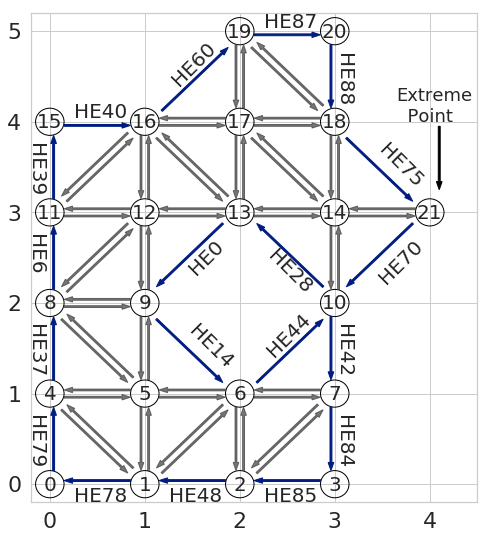

In [4]:
points, poly = fake_building(x_dim=[0, 4, 1], y_dim=[0, 4, 1], holes=[[2,2,0.5]])
add_point = np.array([[4, 3]])
points = np.concatenate((points, add_point))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))

delaunay, planes, polygons = extractPlanesAndPolygons(points, xyThresh=1.5, minTriangles=10, alpha=0.0)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
# mask = get_mask(triangles, planes)
# plot_triangles(ax, points, triangles, mask=mask,lw=1.0)
# plot_points(ax, points, color='black')
exclude_list = [5, 12, 17] # maybe add this i dont know
plot_circle_points(ax, points, fontsize=20)
plot_halftriangles(ax, points, delaunay, planes[0], tri_num=False, edge_num=True, border_edge_num_only=True, fontsize=20)
map_bounds = poly.bounds
scale_axes([map_bounds[0], map_bounds[2]], [
            map_bounds[1], map_bounds[3]], ax)

xp = [4, 3]
xp_arrow = [3.65, 4.0]
ax.text(xp_arrow[0], xp_arrow[1], "Extreme\n  Point", fontsize=18)
ax.arrow(xp_arrow[0]+.45, xp_arrow[1] - .05, -0.00, -0.70, color='black', length_includes_head=True, shape='full', width=0.02)
# ax.axis('equal')
scale_axes([-0.2, 4.5], [-0.2, 5.2], ax)


fig.savefig('assets/pics/algorithm1_visual.pdf', bbox_inches='tight')
# NOTE this is triangles are going clocwise in this right hand coordinate system
# x -> right, y-> up (not down!)


## Hole Handling Explained

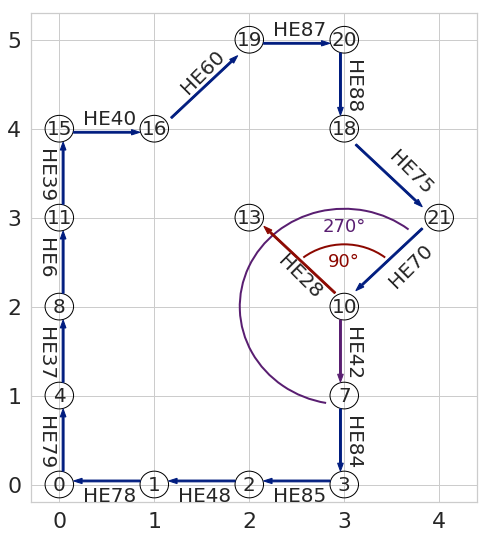

In [5]:
points, poly = fake_building(x_dim=[0, 4, 1], y_dim=[0, 4, 1], holes=[[2,2,0.5]])
add_point = np.array([[4, 3]])
points = np.concatenate((points, add_point))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))

delaunay, planes, polygons = extractPlanesAndPolygons(points, xyThresh=1.5, minTriangles=10, alpha=0.0)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
# mask = get_mask(triangles, planes)
# plot_triangles(ax, points, triangles, mask=mask,lw=1.0)
# plot_points(ax, points, color='black')
exclude_point_list = [5, 6, 9, 12, 14, 24, 17] # dont plot these points
exclude_edge_list = [0, 14, 44, 28, 42] # Dont plot these edges
plot_circle_points(ax, points, fontsize=20,exclude_list=exclude_point_list)
plot_halftriangles(ax, points, delaunay, planes[0], tri_num=False, edge_num=True, 
                   border_edge_num_only=True, fontsize=20, plot_border_only=True,
                  skip_edges=exclude_edge_list)
map_bounds = poly.bounds
scale_axes([map_bounds[0], map_bounds[2]], [
            map_bounds[1], map_bounds[3]], ax)

xp = [4, 3]
xp_arrow = [3.65, 4.0]
# ax.text(xp_arrow[0], xp_arrow[1], "Extreme\n  Point", fontsize=18)
# ax.arrow(xp_arrow[0]+.45, xp_arrow[1] - .05, -0.00, -0.70, color='black', length_includes_head=True, shape='full', width=0.02)
# ax.axis('equal')
scale_axes([-0.3, 4.4], [-0.2, 5.3], ax)


# Plot Orange Edge for Hole
tri_hash = build_tri_hash(planes[0])
edgeclass, edges = build_edge_classification(points, delaunay, planes[0], tri_hash)

ls_he28 = edges[28]
plot_arrow(ax, ls_he28, color=RED, width=0.02, scale_factor=0.75, 
           offset=0.04, offset_side='right', shape='full',index='HE28', length_includes_head=True, fontsize=20)

ls_he28 = edges[42]
plot_arrow(ax, ls_he28, color=PURPLE, width=0.02, scale_factor=0.70, 
           offset=0.04, offset_side='right', shape='full',index='HE42', length_includes_head=True, fontsize=20)

# Plot Hole Arc
center = [3,2]
radius = 0.7
width = 2
height = 2 
start_angle = 52
end_angle = 128
color = RED
text_radius = 0.5
text_angle = '90' + u'\N{DEGREE SIGN}'

add_arc(ax, center, radius, width, height, start_angle, end_angle, color, text_radius, text_angle)

# Plot Shell Arc
end_angle = 260
text_angle = '270' + u'\N{DEGREE SIGN}'
radius = 1.1
text_angle_actual = 90
text_radius = 0.9
color = PURPLE
add_arc(ax, center, radius, width, height, start_angle, end_angle, 
        color, text_radius, text_angle, text_angle_actual=text_angle_actual)



fig.savefig('assets/pics/example_one_hole_choice_visual.pdf', bbox_inches='tight')
# NOTE this is triangles are going clocwise in this right hand coordinate system
# x -> right, y-> up (not down!)


## Final Extracted Polygon

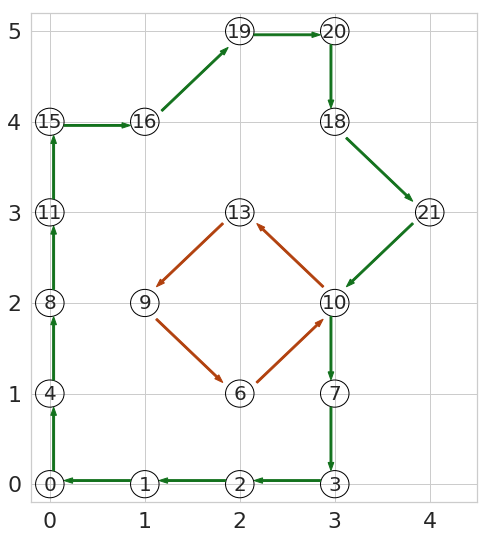

In [6]:
points, poly = fake_building(x_dim=[0, 4, 1], y_dim=[0, 4, 1], holes=[[2,2,0.5]])
add_point = np.array([[4, 3]])
points = np.concatenate((points, add_point))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))

delaunay, planes, polygons = extractPlanesAndPolygons(points, xyThresh=1.5, minTriangles=10, alpha=0.0)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)

exclude_point_list = [5, 12, 14, 24, 17] # dont plot these points
hole_edges = [0, 28, 14, 44]
# exclude_point_list = []
exclude_list = [5, 12, 17] # maybe add this i dont know
plot_circle_points(ax, points, fontsize=20, exclude_list=exclude_point_list)
plot_halftriangles(ax, points, delaunay, planes[0],tri_color=(GREEN, GREEN_LIGHT), tri_num=False, 
                   edge_num=False, border_edge_num_only=True, plot_border_only=True, fontsize=20,
                   hole_edges=hole_edges, hole_color=ORANGE)
map_bounds = poly.bounds
scale_axes([map_bounds[0], map_bounds[2]], [
            map_bounds[1], map_bounds[3]], ax)


# ax.axis('equal')
scale_axes([-0.2, 4.5], [-0.2, 5.2], ax)


fig.savefig('assets/pics/example_one_complete.pdf', bbox_inches='tight')
# NOTE this is triangles are going clocwise in this right hand coordinate system
# x -> right, y-> up (not down!)


## Connected Hole Handling Explained

(0.0, 0.0, 5.0, 5.0)


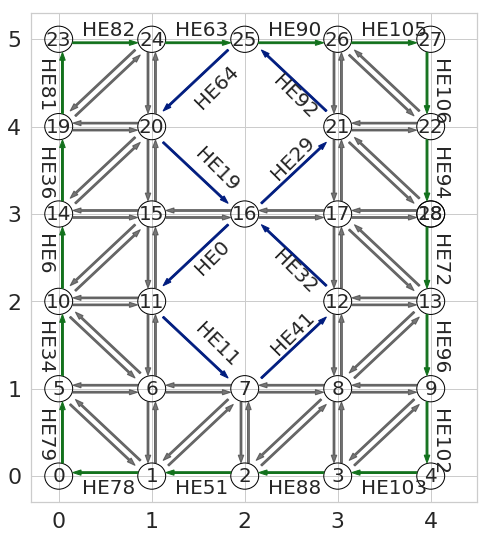

In [7]:
points, poly = fake_building(x_dim=[0, 5, 1], y_dim=[0, 5, 1], build_arm=False, holes=[[2,2,0.5], [2,4,0.5]])
add_point = np.array([[4, 3]])
points = np.concatenate((points, add_point))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))

delaunay, planes, polygons = extractPlanesAndPolygons(points, xyThresh=1.5, minTriangles=10, alpha=0.0)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
# mask = get_mask(triangles, planes)
# plot_triangles(ax, points, triangles, mask=mask,lw=1.0)
# plot_points(ax, points, color='black')
exclude_point_list = [] # dont plot these points
exclude_edge_list = [] # Dont plot these edges
hole_edges = [64, 92, 29, 19, 0, 32, 11, 41]
plot_circle_points(ax, points, fontsize=20,exclude_list=exclude_point_list)
plot_halftriangles(ax, points, delaunay, planes[0], tri_color=(GREEN, GREEN_LIGHT), tri_num=False, edge_num=True, 
                   border_edge_num_only=True, fontsize=20, plot_border_only=False,
                   skip_edges=exclude_edge_list, hole_edges=hole_edges)
map_bounds = poly.bounds
print(map_bounds)
scale_axes([map_bounds[0], map_bounds[2]],
           [map_bounds[1], map_bounds[3]], ax)

scale_axes([-0.3, 4.5], [-0.3, 5.3], ax)

fig.savefig('assets/pics/example_2_all.pdf', bbox_inches='tight')

(0.0, 0.0, 5.0, 5.0)


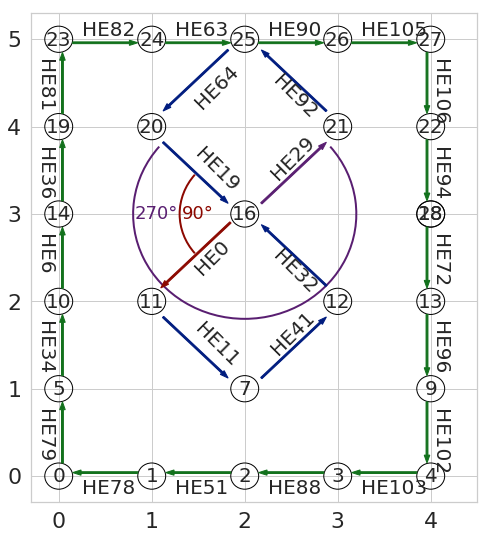

In [8]:
points, poly = fake_building(x_dim=[0, 5, 1], y_dim=[0, 5, 1], build_arm=False, holes=[[2,2,0.5], [2,4,0.5]])
add_point = np.array([[4, 3]])
points = np.concatenate((points, add_point))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))

delaunay, planes, polygons = extractPlanesAndPolygons(points, xyThresh=1.5, minTriangles=10, alpha=0.0)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
# mask = get_mask(triangles, planes)
# plot_triangles(ax, points, triangles, mask=mask,lw=1.0)
# plot_points(ax, points, color='black')
exclude_point_list = [15, 17, 6, 8] # dont plot these points
exclude_edge_list = [0, 29] # Dont plot these edges
hole_edges = [64, 92, 29, 0, 32, 11, 41, 19]
# hole_edges = []
plot_circle_points(ax, points, fontsize=20,exclude_list=exclude_point_list)
plot_halftriangles(ax, points, delaunay, planes[0], tri_color=(GREEN, GREEN_LIGHT), tri_num=False, edge_num=True, 
                   border_edge_num_only=True, fontsize=20, plot_border_only=True,
                   skip_edges=exclude_edge_list, hole_edges=hole_edges)
map_bounds = poly.bounds
print(map_bounds)
scale_axes([map_bounds[0], map_bounds[2]],
           [map_bounds[1], map_bounds[3]], ax)

# xp = [4, 3]
# xp_arrow = [3.65, 4.0]
# ax.text(xp_arrow[0], xp_arrow[1], "Extreme\n  Point", fontsize=18)
# ax.arrow(xp_arrow[0]+.45, xp_arrow[1] - .05, -0.00, -0.70, color='black', length_includes_head=True, shape='full', width=0.02)
# # ax.axis('equal')
scale_axes([-0.3, 4.5], [-0.3, 5.3], ax)

# Plot Orange Edge for Hole
tri_hash = build_tri_hash(planes[0])
edgeclass, edges = build_edge_classification(points, delaunay, planes[0], tri_hash)

ls_he0 = edges[0]
plot_arrow(ax, ls_he0, color=RED, width=0.02, scale_factor=0.75, 
           offset=0.04, offset_side='right', shape='full',index='HE0', length_includes_head=True, fontsize=20)

ls_he29 = edges[29]
plot_arrow(ax, ls_he29, color=PURPLE, width=0.02, scale_factor=0.70, 
           offset=0.04, offset_side='right', shape='full',index='HE29', length_includes_head=True, fontsize=20)

# Plot Hole Arc
center = [2,3]
radius = 0.7
width = 2
height = 2 
start_angle = 140
end_angle = 220
color = RED
text_radius = 0.5
text_angle = '90' + u'\N{DEGREE SIGN}'

add_arc(ax, center, radius, width, height, start_angle, end_angle, color, text_radius, text_angle)

# Plot Shell Arc
end_angle = 40
text_angle = '270' + u'\N{DEGREE SIGN}'
radius = 1.2
text_angle_actual = 180
text_radius = 0.95
color = PURPLE
add_arc(ax, center, radius, width, height, start_angle, end_angle, 
        color, text_radius, text_angle, text_angle_actual=text_angle_actual)

fig.savefig('assets/pics/example_2_choice.pdf', bbox_inches='tight')
# fig.savefig('assets/pics/algorithm1_visual.pdf', bbox_inches='tight')
# NOTE this is triangles are going clocwise in this right hand coordinate system
# x -> right, y-> up (not down!)


In [9]:
# np.random.seed(1)
# num_points = 50
# std = 0.25
# x = np.random.normal(0, std, size=num_points) * 10
# y = np.random.normal(0, std, size=num_points) * 10
# points = np.column_stack((x,y))
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

# delaunay, planes, polygons = extractPlanesAndPolygons(points, alpha=0.9)
# triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
# mask_array = np.ones(triangles.shape[0], dtype=bool)
# mask_array[planes[0]] = False
# # mask_array = ~mask_array
# plot_points(ax, points)
# plot_halftriangles(ax, points, delaunay, planes[0])
# map_bounds = poly.bounds
# scale_axes([map_bounds[0], map_bounds[2]], [
#             map_bounds[1], map_bounds[3]], ax)
# ax.axis('equal')


## Simple Example of Delaunator Data Structure

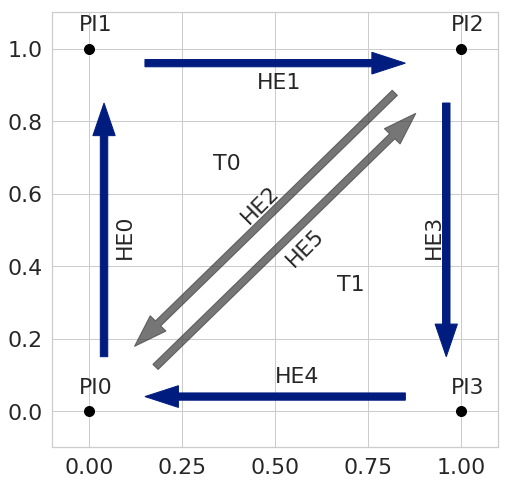

In [10]:
points = np.array([[0,0], [0, 1], [1,1], [1,0]], dtype=float)

edge_labels = [
    ('HE3', (0.90, 0.5), 90),
    ('HE4', (0.5, 0.08), 0),
    ('HE5', (0.52, 0.47), 45),
    ('HE0', (0.07, 0.5), 90),
    ('HE1', (0.45, 0.89), 0),
    ('HE2', (0.40, 0.590), 45),
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

delaunay, planes, polygons = extractPlanesAndPolygons(points, alpha=0.9, minTriangles=1)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
mask_array = np.ones(triangles.shape[0], dtype=bool)
mask_array[planes[0]] = False
# mask_array = ~mask_array
plot_points(ax, points, color='black', s=100, plot_text=True, fontsize=22)
plot_halftriangles(ax, points, delaunay, planes[0], tri_num=True, edge_num=False, fontsize=22)
# map_bounds = poly.bounds
scale_axes([-0.1, 1.1], [-0.1, 1 + .1], ax)
plot_text(ax, edge_labels, fontsize=22)
fig.savefig('assets/pics/delaunator_tri.pdf', bbox_inches='tight')
# ax.axis('equal')

## Simple Example of Plane Extraction

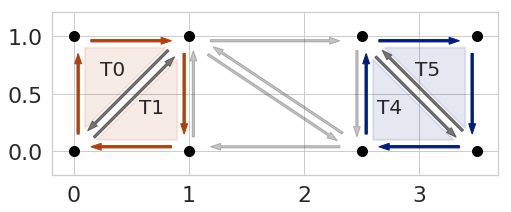

In [11]:
points = np.array([[0,0], [0, 1], [1,1], [1,0]], dtype=float)

points2 = points + np.array([2.5, 0])
points = np.concatenate((points, points2))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))

delaunay, planes, polygons = extractPlanesAndPolygons(points, alpha=0.9, minTriangles=1)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
mask_array = np.ones(triangles.shape[0], dtype=bool)
mask_array[planes[0]] = False
# mask_array = ~mask_array
plot_points(ax, points, color='black', s=100, plot_text=False, fontsize=22)
plot_halftriangles(ax, points, delaunay, planes[0], tri_num=True, shade_tri=True, edge_num=False, text_factor=.20, fontsize=20)
plot_halftriangles(ax, points, delaunay, planes[1], tri_color=(ORANGE, ORANGE_LIGHT), tri_num=True, shade_tri=True, edge_num=False, text_factor=.10, fontsize=20)
plot_removed_edges(ax, points, delaunay, planes)

ax.axis('equal')
fig.savefig('assets/pics/plane_extraction_a.pdf', bbox_inches='tight')

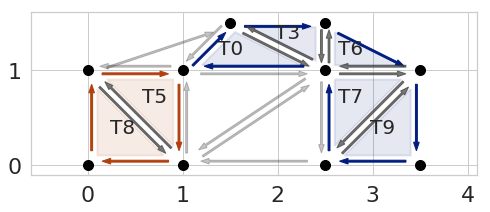

In [12]:
points = np.array([[0,0], [0, 1], [1,1], [1,0]], dtype=float)
points2 = points + np.array([2.5, 0])
points3 = np.array([[1.5, 1.5], [2.5, 1.5]])
points = np.concatenate((points, points2, points3))


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))

delaunay, planes, polygons = extractPlanesAndPolygons(points, alpha=0.9, minTriangles=1)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
mask_array = np.ones(triangles.shape[0], dtype=bool)
mask_array[planes[0]] = False
# mask_array = ~mask_array
plot_points(ax, points, color='black', s=100, plot_text=False, fontsize=22)
plot_halftriangles(ax, points, delaunay, planes[0], tri_num=True, shade_tri=True, edge_num=False, text_factor=.20, fontsize=20)
plot_halftriangles(ax, points, delaunay, planes[1], tri_color=(ORANGE, ORANGE_LIGHT), tri_num=True, shade_tri=True, edge_num=False, text_factor=.10, fontsize=20)
plot_removed_edges(ax, points, delaunay, planes)

ax.axis('equal')
fig.savefig('assets/pics/plane_extraction_b.pdf', bbox_inches='tight')